In [1]:
import pandas as pd
import numpy as np
import datetime 
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# To Plot matplotlib figures inline on the notebook
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search
from sklearn.model_selection import GridSearchCV

In [3]:
data = pd.read_csv('Traffic_Crashes_-_Crashes.csv')

In [4]:
### Setting up the data table again

In [5]:
data=data.drop(['STATION','NAME','DATE','CRASH_DATE','POSTED_SPEED_LIMIT','CRASH_DATE_ADJ'], axis=1)
columns = ['WEATHER_CONDITION', 'LIGHTING_CONDITION', 'BEAT_OF_OCCURRENCE']
for col in columns:
    tmp_df = pd.get_dummies(data[col], prefix=col)
    data = pd.concat((data, tmp_df), axis=1)
data=data.drop(['WEATHER_CONDITION','LIGHTING_CONDITION','BEAT_OF_OCCURRENCE'], axis=1)
data=data.drop(['COUNTER'], axis=1)
data['INJURIES_TOTAL'].apply(lambda x: (x and 0) or x > 1)
data['ACCIDENT_LEVEL']=(data['INJURIES_TOTAL'] > 0).astype(int)
data=data.drop(['INJURIES_TOTAL','INJURIES_FATAL'], axis=1)
X = data.iloc[:, 0:293]
y = data.ACCIDENT_LEVEL

In [6]:
#Check out y counts for no injures and injuries

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)

In [8]:
y_train.value_counts()

0    147945
1     18449
Name: ACCIDENT_LEVEL, dtype: int64

In [103]:
y_test.value_counts()

0    16408
1     2081
Name: ACCIDENT_LEVEL, dtype: int64

In [9]:
# Upsampling to even out ratios 

In [68]:
from collections import Counter
import imblearn.over_sampling

#multiply by 2x

ROS = imblearn.over_sampling.RandomOverSampler(\
                                     ratio={0:int(164353) , 1:int(20530*6)}, \
                                     random_state = 42)
#0:164353 ; 1:20530*6
X_tr_ROS, y_tr_ROS = ROS.fit_sample(X_train,y_train)


'''Increase the injuries samples from 20,530 to 123,180'''

print('Resampled dataset shape {}'.format(Counter(y_tr_ROS)))

/anaconda3/lib/python3.6/site-packages/imblearn/utils/validation.py:224: UserWarning: After over-sampling, the number of samples (164353) in class 0 will be larger than the number of samples in the majority class (class #0 -> 147945)
  n_samples_majority))


Resampled dataset shape Counter({0: 164353, 1: 123180})


In [78]:
#Train, Test, Split

In [69]:
'''Split the resampled data into train & test data with 70:30 mix'''

Xtrain_res, Xtest_res, ytrain_res, ytest_res = train_test_split(X_tr_ROS, y_tr_ROS, test_size=0.30, random_state=1)
print('xtrain shape')
print(Xtrain_res.shape)
print('xtest shape')
print(Xtest_res.shape)

xtrain shape
(201273, 293)
xtest shape
(86260, 293)


### Logistic Regression

In [92]:
logitreg_gs = LogisticRegression()
parameters = {'penalty':['l1','l2'] , 'C' : [15,16,17,18,19,20,21], 'random_state': [44]}
grid_lr = GridSearchCV(logitreg_gs , parameters, cv=3, scoring='f1_weighted', n_jobs=1)
grid_lr.fit(X_tr_ROS, y_tr_ROS)
print(grid_lr.best_params_, grid_lr.best_score_)
#15

{'C': 17, 'penalty': 'l2', 'random_state': 44} 0.5678109056126639


In [93]:
print(classification_report(y_train, grid_lr.predict(X_train)))
print(confusion_matrix(y_train, grid_lr.predict(X_train)))


             precision    recall  f1-score   support

          0       0.90      0.83      0.86    147945
          1       0.17      0.29      0.22     18449

avg / total       0.82      0.77      0.79    166394

[[122274  25671]
 [ 13037   5412]]


In [94]:
print(classification_report(y_test, grid_lr.predict(X_test)))
print(confusion_matrix(y_test, grid_lr.predict(X_test)))

             precision    recall  f1-score   support

          0       0.90      0.82      0.86     16408
          1       0.17      0.28      0.21      2081

avg / total       0.82      0.76      0.79     18489

[[13499  2909]
 [ 1503   578]]


## KNN Oversampling

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [38]:
n_neighbors = range(1,20)
knn_accuracy = list()
knn_recall = list()

for n in n_neighbors:
    knn = KNeighborsClassifier(n)
    knn.fit(Xtrain_res, ytrain_res)
    knn_prediction = knn.predict(X_test)
    knn_accuracy.append(accuracy_score(y_test, knn_prediction))
    knn_recall.append(recall_score(y_test, knn_prediction))
    

Text(0.5,1,'KNN Model - Accuracy, Recall vs Neighbors')

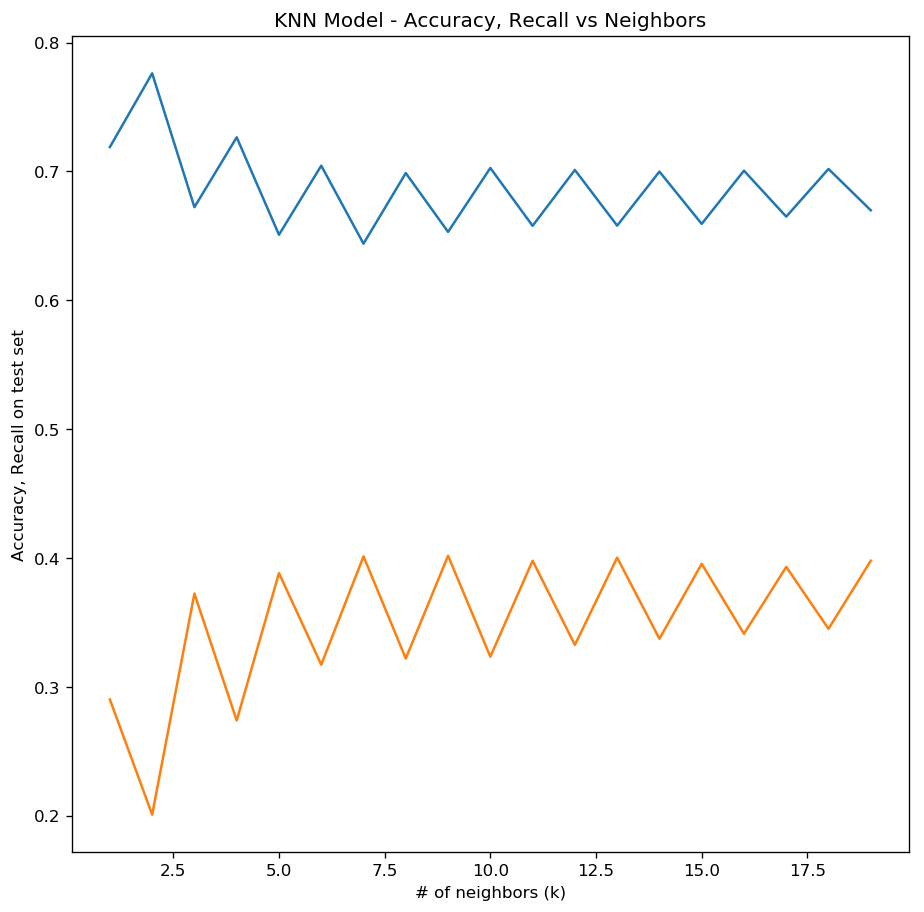

In [39]:
plt.figure(figsize=(9,9), dpi=120)
plt.plot(n_neighbors, knn_accuracy)
plt.plot(n_neighbors, knn_recall)
plt.xlabel('# of neighbors (k)')
plt.ylabel('Accuracy, Recall on test set')
plt.title('KNN Model - Accuracy, Recall vs Neighbors')

In [41]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7) #5 
knn.fit(Xtrain_res, ytrain_res)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [102]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytrain_res, knn.predict(Xtrain_res)))
print(confusion_matrix(ytest_res, knn.predict(Xtest_res)))
print(confusion_matrix(y_test, knn.predict(X_test)))

[[87678 27214]
 [ 4616 81765]]
[[34020 15441]
 [ 4404 32395]]
[[11070  5338]
 [ 1246   835]]


In [43]:
confusion_matrix(y_test, knn.predict(X_test))


array([[11070,  5338],
       [ 1246,   835]])

In [40]:
#5
#array([[11225,  5183],
#       [ 1273,   808]])

# Naive Baise Oversampling

In [30]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(Xtrain_res, ytrain_res)
print(nb.score(X_train, y_train))
print(nb.score(X_test, y_test))

0.5958928807529118
0.5895938125371842


In [31]:
from sklearn.metrics import confusion_matrix, classification_report

In [33]:
print(classification_report(y_test, nb.predict(X_test)))
print(confusion_matrix(y_test, nb.predict(X_test)))


             precision    recall  f1-score   support

          0       0.91      0.60      0.72     16408
          1       0.14      0.51      0.22      2081

avg / total       0.82      0.59      0.67     18489

[[9831 6577]
 [1011 1070]]


In [35]:
print(classification_report(y_train, nb.predict(X_train)))
print(confusion_matrix(y_train, nb.predict(X_train)))


             precision    recall  f1-score   support

          0       0.91      0.60      0.73    147945
          1       0.14      0.53      0.23     18449

avg / total       0.83      0.60      0.67    166394

[[89357 58588]
 [ 8653  9796]]


# Random Forest Oversampling

In [48]:
from sklearn.model_selection import cross_val_score
import sklearn.metrics as mt

In [52]:
rf = RandomForestClassifier(n_estimators = 28) #20
rf.fit(Xtrain_res, ytrain_res)
       
rf_predictions = rf.predict(X_test)

#print(rf.score(X_test, y_test))
scores = cross_val_score(rf, X_test, y_test, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(mt.classification_report(y_test, rf_predictions))
print(mt.confusion_matrix(y_test, rf_predictions))

[0.87510138 0.87804218 0.87479719 0.87584528 0.8725994 ]
Accuracy: 0.88 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.89      0.91      0.90     16408
          1       0.15      0.12      0.13      2081

avg / total       0.81      0.82      0.82     18489

[[14976  1432]
 [ 1833   248]]


In [53]:
rf = RandomForestClassifier(n_estimators = 30) #20
rf.fit(Xtrain_res, ytrain_res)
       
rf_predictions = rf.predict(X_test)

#print(rf.score(X_test, y_test))
scores = cross_val_score(rf, X_test, y_test, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(mt.classification_report(y_test, rf_predictions))
print(mt.confusion_matrix(y_test, rf_predictions))

[0.87510138 0.87750135 0.87425635 0.87611577 0.8753043 ]
Accuracy: 0.88 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.89      0.91      0.90     16408
          1       0.14      0.12      0.13      2081

avg / total       0.81      0.82      0.81     18489

[[14971  1437]
 [ 1839   242]]


### Gridsearch on Random Forest

In [73]:
rfgrid = RandomForestClassifier()
parameters = {'criterion':['gini','entropy'],'n_estimators': [26,28,29,30,31], 'random_state': [2]}
gridrf = GridSearchCV(rfgrid , parameters, cv=3, scoring='f1_weighted', n_jobs=1)
gridrf.fit(Xtrain_res, ytrain_res)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'n_estimators': [26, 28, 29, 30, 31], 'random_state': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [77]:
print(gridrf.best_params_, gridrf.best_score_)

{'criterion': 'gini', 'n_estimators': 30, 'random_state': 2} 0.9133301098518555


### Testing on regular data with fitted random forest (missing look at top)

# Decision Tree Oversampling

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier


dt = DecisionTreeClassifier()

In [82]:
dt.fit(Xtrain_res, ytrain_res)
dt.score(Xtest_res, ytest_res)

0.8878248696463714

### Gridsearch on Decision Tree

In [114]:
dt_gs = DecisionTreeClassifier()
parameters = {'criterion':['gini','entropy'],'max_depth': [276,277,278,279,280,281], 'max_features': ['auto', 'sqrt'], 'random_state': [3]}
dt_gs = GridSearchCV(dt_gs , parameters, cv=3, scoring='f1_weighted', n_jobs=1)
dt_gs.fit(Xtrain_res, ytrain_res)
#70,#50 #130



GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [276, 277, 278, 279, 280, 281], 'max_features': ['auto', 'sqrt'], 'random_state': [3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [115]:
print(dt_gs.best_params_, dt_gs.best_score_)

{'criterion': 'gini', 'max_depth': 280, 'max_features': 'auto', 'random_state': 3} 0.87541300843366


In [116]:
print(mt.classification_report(y_test, dt_gs.predict(X_test)))
print(mt.confusion_matrix(y_test, dt_gs.predict(X_test)))

             precision    recall  f1-score   support

          0       0.89      0.85      0.87     16408
          1       0.14      0.20      0.17      2081

avg / total       0.81      0.78      0.79     18489

[[13989  2419]
 [ 1674   407]]


# XGBoosted Oversampling

In [ ]:
import xgboost as xgb


Xtrain_res_, Xtrain_res_val_, ytrain_res_, ytrain_res_val_ = train_test_split(Xtrain_res, ytrain_res, test_size=0.25, random_state=41)


In [ ]:
gbm = xgb.XGBClassifier(
                       n_estimators=800000, #arbitrary large number
                       max_depth=7,
                       objective='binary:logistic',
                       learning_rate=.08, #.1
                       subsample=1,
                       min_child_weight=6, #
                       colsample_bytree=.8
                      )

eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error',
                    early_stopping_rounds=9,
                    verbose=True #gives output log as below
                   )

# BEST MODEL: Random Forest

In [104]:
import itertools
import seaborn as sns

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges): #plt.cm.Oranges
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = (100*cm.astype('float')) / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[13499  2909]
 [ 1503   578]]
Normalized confusion matrix
[[82.27 17.73]
 [72.22 27.78]]


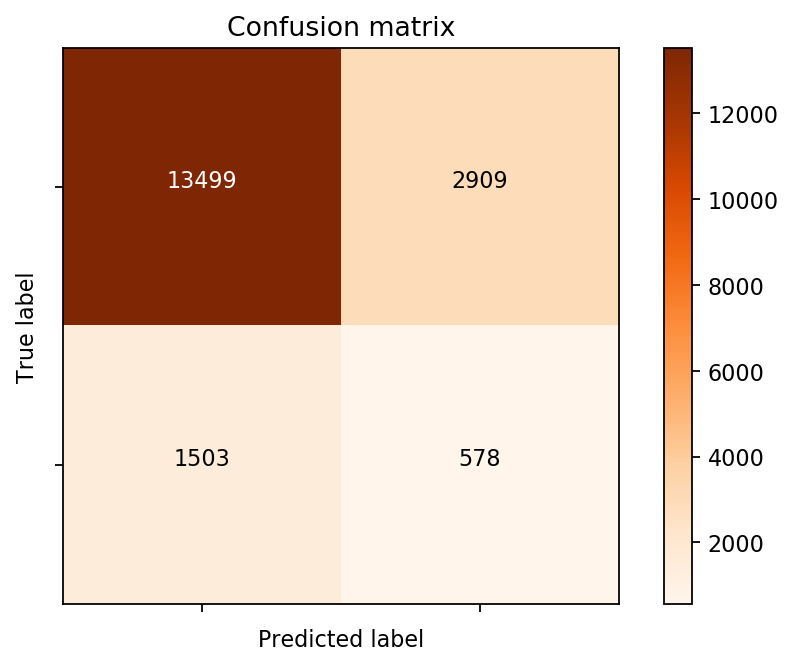

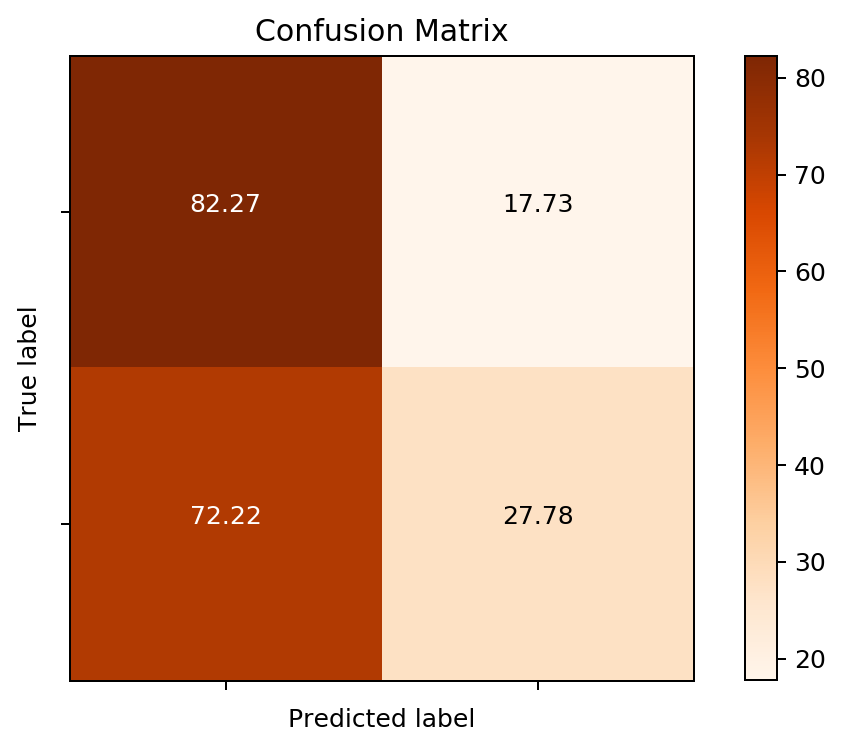

In [105]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, grid_lr.predict(X_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(dpi=160)
plot_confusion_matrix(cnf_matrix, classes=['', ''], title='Confusion matrix')

# Plot normalized confusion matrix
plt.figure(dpi=180)
plot_confusion_matrix(cnf_matrix, classes=['', ''], normalize=True, title='Confusion Matrix')

plt.show()

Confusion matrix, without normalization
[[13989  2419]
 [ 1674   407]]
Normalized confusion matrix
[[85.26 14.74]
 [80.44 19.56]]


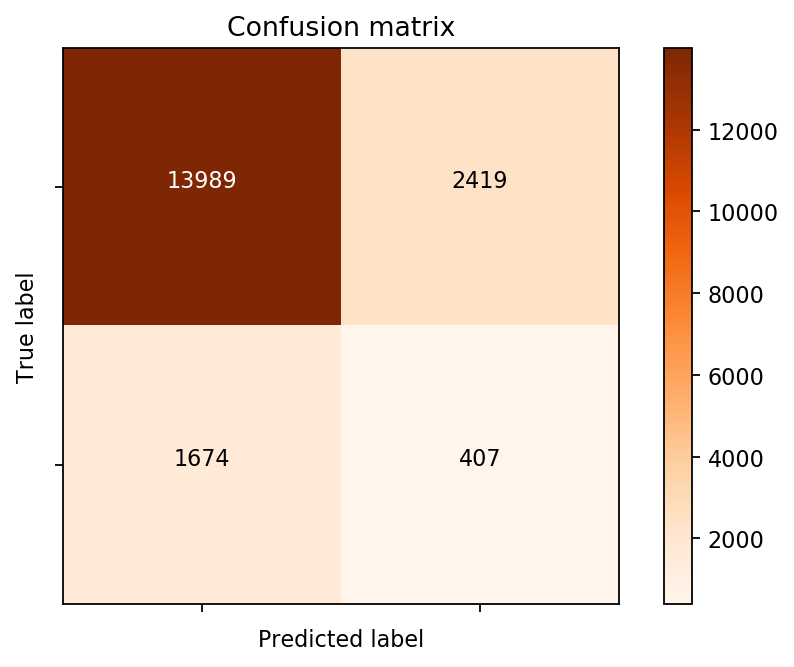

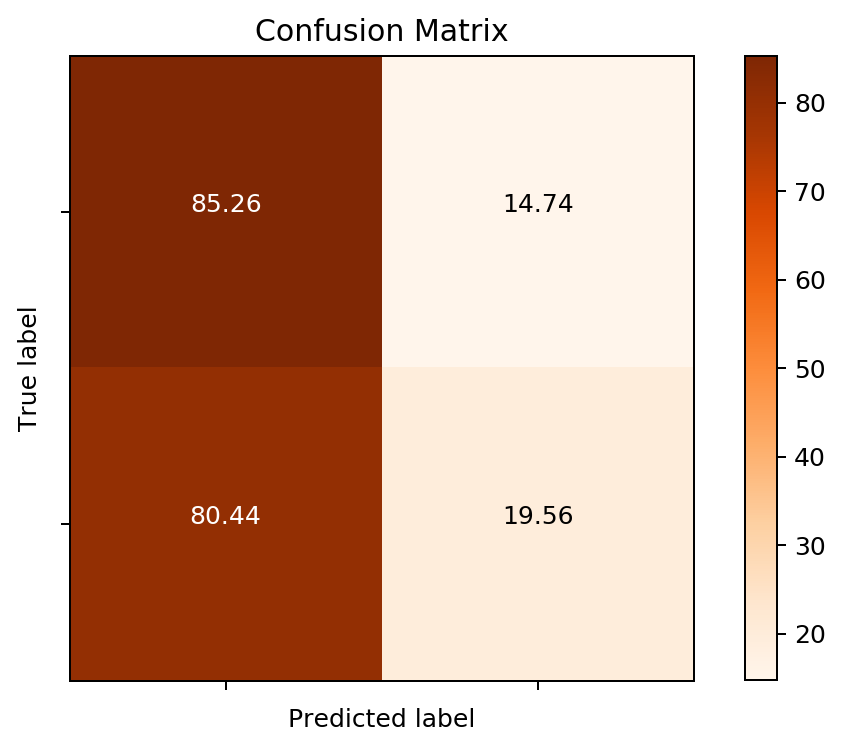

In [112]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, dt_gs.predict(X_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(dpi=160)
plot_confusion_matrix(cnf_matrix, classes=['', ''], title='Confusion matrix')

# Plot normalized confusion matrix
plt.figure(dpi=180)
plot_confusion_matrix(cnf_matrix, classes=['', ''], normalize=True, title='Confusion Matrix')

plt.show()